## Part 1

In [2]:
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#getting the directory for the stored CSV's for the flow only case
csvdir = "C:\\Users\\Harrison\\OneDrive - University of Cincinnati\\Year 5\\Aero Lab\\Lab Work\\Lab 4\\Lab Data\\Flow only, vectors"

#importing the csv files
csvfiles = glob.glob(os.path.join(csvdir, "*.csv"))

#creating an array to store the imported csv dataframes
dataframes = []

for csvfile in csvfiles:
    df = pd.read_csv(csvfile) #reading each csv file
    dataframes.append(df) #adding the dataframe from the csv into the dataframes array

The cylinder and wing are placed in the freestream where the effects from the walls (bottom of tunnel, top of water) are the lowest, therefore we want to use that velocity to determine Reynold's number. For each frame, every row (y position) will be averaged and then all the frame rows will be averaged (gives v_avg row 1, v_avg row 2, etc.). Plotting the data will show which rows are the highest, and therefore the freestream. The freestream rows will then be averaged and the resulting speed will be used in the Re number calculation.

In [3]:
avg_speed = []
row = 0
print(len(dataframes))

for k in range(len(dataframes)):
    df = dataframes[k] #getting individual frame data
    speeds = []
    speed_arr = []

    for i in range(len(df)): 
        u = df.loc[i][2] #getting u component
        v = df.loc[i][3] #getting v component
        speed = np.sqrt(u**2 + v**2) #calculating speed for the position
        speed_arr.append(speed) #adding the speed value to the array

    avg_speed.append(np.average(speed_arr)) #average speed for the frame

    #counter to help track progress
    if k/100 == int(k/100):
        print("Frame {}".format(k))


print(avg_speed) #printing the avg speed array
flow_speed = np.average(avg_speed) #calculating the average flow speed
print(flow_speed) #displaying average flow speed


497
Frame 0
Frame 100
Frame 200
Frame 300
Frame 400
[130.3548471191971, 126.15378728424561, 132.26757131617072, 131.58078558260743, 130.36974698168484, 133.8948458231916, 126.10830908896192, 131.65680222803297, 131.87974640730744, 129.93911455982615, 129.54904677530115, 129.64044950609906, 124.33031740642686, 121.34575243040983, 128.22559724311532, 132.40908866533752, 129.06469459011294, 128.36724322595086, 126.2744023979616, 120.51773955080462, 123.96702874779533, 133.29055398835223, 127.21012894239747, 131.66495039534564, 129.32719080333177, 131.68971155020233, 129.81296783023308, 130.18470210399386, 129.15898591807107, 128.95937585412594, 128.154539390093, 128.7923291656114, 126.6139467583996, 128.384450493172, 130.984318441854, 125.15926993435778, 127.6651241089155, 128.64474941467776, 127.72587213817698, 126.30643926147206, 127.74174808080602, 119.94125050881074, 128.12948004850207, 126.83108396834007, 127.68372911680338, 126.93364789031672, 130.74776830207205, 127.28791887012214,

In [4]:
#constants
rho = 997 #kg/m^3
mu = 1.002E-3 #Ns/m^2
flow_speed = np.average(avg_speed)/1000 #m/s
r_c = 101.6 #mm
r_t = 57.66 #mm
Cyl_dia = 1.5/39.37 #m

t = (r_t/r_c) #non-dimensional, taper ratio
MAC = r_c * .66 * ((1+t+t**2)/(1+t))/1000 #m, mean aerodynamic chord

Re_cyl = (rho*flow_speed*Cyl_dia)/mu
Re_MAC = (rho*flow_speed*MAC)/mu

print("Re_cyl: {:.3f} \nRe_MAC: {:.3f}".format(Re_cyl, Re_MAC))

Re_cyl: 4520.760 
Re_MAC: 9591.350


# Part 2
A python function will take in the instantaneous vector fields for each image and then average the entire window to get the average vector field. The averaged mean turbulence RMS will also be computed 

In [5]:
#thought out method:
## Part A: Compiling all the data
# 1. Open the folder that contains the csv files
# 2. Open each csv file and then place the data into a dataframe and then into an array
# 3. Generate a panda's data frame (rows = frame #, columns = vector at position) [refer as total frame]

## Part B: Determining the mean velocity field
# 4. Calculate the vector for each position (per frame) and then populate the corresponding cell of the data frame
# 5. After all frames have been analyzed, find the average vector value for each column (if a cell is NaN, 0, -1.#ND, etc. it is not included)(every column is the same position between frames)
# 6. Populate the Average_data_frame with the average vector value (row = position, column = vector)

## Part C: Determining the RMS mean velocity field
# 7. Using the total data frame, subtract the mean velocity from each position
# 8. Populate new total_RMS_frame
# 9. Average the columns, and populate the RMS_data_frame

In [198]:
## Part A.1 and A.2 ##

#getting the directory for the stored CSV's for the flow only case (ensure all \ are \\)
csvdir = "C:\\Users\\Harrison\\OneDrive - University of Cincinnati\\Year 5\\Aero Lab\\Lab Work\\Lab 4\\Masked Data\\Airfoil AoA\\23-10-31 15.58.40"

#importing the csv files
csvfiles = glob.glob(os.path.join(csvdir, "*.csv"))

#creating an array to store the imported csv dataframes
dataframes = []

for csvfile in csvfiles:
    df = pd.read_csv(csvfile) #reading each csv file
    dataframes.append(df) #adding the dataframe from the csv into the dataframes array

In [199]:
## Part A.3 & B.4 ##
#importing time to track how long it takes to compute
import time

#creating a dataframe with number of columns equal to the number of data points
#the row is equal to the frame # while the column # is the position of the vector
dt = dataframes[0]
vector_total_frame = pd.DataFrame(columns=np.arange(len(dt)))
u_total_frame = pd.DataFrame(columns=np.arange(len(dt)))
v_total_frame = pd.DataFrame(columns=np.arange(len(dt)))

for k in range(len(dataframes)):
    dt = dataframes[k]
    vector_values = []
    u_values = []
    v_values = []

    #initial time
    if k/100 == int(k/100):
        time0 = time.time()
    
    #computing the vector for each position
    for i in range(len(dt)):
        vector = np.sqrt((dt.loc[i][2]*(1/1.3499/0.019))**2 + (dt.loc[i][3]*(1/1.3499/0.019))**2) #calculating the vector
        vector_values.append(vector) #adding vector value to array
        u_values.append(dt.loc[i][2]*(1/1.3499/0.019)) #u values
        v_values.append(dt.loc[i][3]*(1/1.3499/0.019)) #v values
        
    #adding the computed vectors to the total_data frame
    vector_total_frame.loc[k] = vector_values 
    u_total_frame.loc[k] = u_values
    v_total_frame.loc[k] = v_values

    if k/100 == int(k/100):
        timef = time.time() #time after computation
        timet = timef - time0
        print("Frame {:.1f} took {:.3f} s to compute".format(k, timet))

Frame 0.0 took 1.853 s to compute
Frame 100.0 took 1.167 s to compute
Frame 200.0 took 1.556 s to compute
Frame 300.0 took 1.178 s to compute
Frame 400.0 took 1.311 s to compute
Frame 500.0 took 1.101 s to compute


In [194]:
#Debugging cell
print(vector_total_frame)

           0           1           2           3           4           5     \
0    137.967830  146.784410  135.000727  136.120386  134.191021  155.349907   
1      0.000000  159.055446  166.757149  172.443384  168.247081  161.249903   
2    100.857760   55.585613  109.263939  156.247022  135.175335  158.071202   
3    148.771461  133.910840  153.381406  171.072775    0.000000  129.570442   
4    163.038223  164.647731  161.226358  164.602347  166.837102  156.039473   
..          ...         ...         ...         ...         ...         ...   
482  116.676004  121.985854  151.428179  182.466069  176.008550  175.064767   
483  106.626164  199.285884  128.514363  148.585317  189.310095  170.016161   
484    0.000000  136.237077  137.152407  154.012343  169.033329  173.880681   
485  136.920977  152.809645  174.000992  168.790797  164.083759    0.000000   
486  165.074610  167.152120  159.699002  155.632677  152.781018  187.392585   

           6           7           8           9   

In [200]:
## Part B.5 and B.6 ##
# Determining the average vector for the cell

#creating the Average_data_frame
Average_data_frame = pd.DataFrame(columns=["x", "y", "u", "v", "vector"])

dt = dataframes[0]

#populating Average_data_frame with the x and y coords
time0 = time.time()
for i in range(len(dt)):
    Average_data_frame.loc[i] = dt.loc[i][0]
    Average_data_frame.loc[i][1] = dt.loc[i][1]
timef = time.time()
print("Positions placed in: {:.2f} s".format(timef-time0))

#calculating the average value
for k in range(len(dt)): #iterating through the columns (each column is a position)
    vector_avg = 0
    u_avg = 0
    v_avg = 0
    v_divider = 0
    u_divider = 0
    vec_divider = 0

    #checking the vectors for if the value is zero or null
    for i in range(len(dataframes)): #iterating the row 
        if vector_total_frame.loc[i][k] != 0: #pd.isnull(total_frame.loc[i][k]) == False:
            vector_avg = vector_avg + vector_total_frame.loc[i][k] #adding the values together
            vec_divider = vec_divider + 1 #number of usable values
        
        if u_total_frame.loc[i][k] != 0:
            u_avg = u_avg + u_total_frame.loc[i][k]
            u_divider = u_divider + 1
        
        if v_total_frame.loc[i][k] != 0:
            v_avg = v_avg + v_total_frame.loc[i][k]
            v_divider = v_divider + 1
        else:
            divider = divider #keeping the divisible number constant
    
    #Calculating the average vector and adding it to the frame
    if u_divider != 0:
        Average_data_frame.loc[k][2] = u_avg/u_divider
    else:
        Average_data_frame.loc[k][2] = 0

    if v_divider != 0:
        Average_data_frame.loc[k][3] = v_avg/v_divider
    else:
        Average_data_frame.loc[k][3] = 0

    if vec_divider != 0:
        Average_data_frame.loc[k][4] = vector_avg/vec_divider
    else:
        Average_data_frame.loc[k][4] = 0 

Average_data_frame.to_csv("Average_Data Airfoil AoA.csv")

# print(Average_data_frame)

Positions placed in: 8.43 s


### ONLY RUN THIS CELL IF IT IS THE FREE STREAM CONDITION

In [173]:
## Getting Free-Stream Values
# u_free_stream = Average_data_frame["u"].to_numpy()
# v_free_stream = Average_data_frame["v"].to_numpy()
# vector_free_stream = Average_data_frame["vector"].to_numpy()

In [201]:
## Part C ##
# Creating the RMS dataframe
RMS = pd.DataFrame(index=np.arange(len(dataframes)), columns=np.arange(len(dt)))

#computing the RMS for each cell
for i in range(len(dataframes)): #row of the Mean_RMS
    for j in range(len(vector_total_frame.loc[0][:])): #columns of Mean_RMS
        RMS.loc[i][j] = (vector_total_frame.loc[i][j] - Average_data_frame.loc[j][4])

print(RMS)


           0           1          2          3          4           5     \
0   -137.482704 -118.505953  17.885414  10.151625  10.945689 -181.301938   
1      3.448242   -5.679162  -9.193632  -3.633633 -13.405415    9.498015   
2     -2.322611   -1.635312 -33.847351 -39.273922 -13.105366  -20.617146   
3     11.457181  -29.916187  49.980527  -42.74781  -6.046783   -13.71047   
4   -156.399417   -3.098804   -4.62012   5.959997  27.168063   -42.23232   
..          ...         ...        ...        ...        ...         ...   
509    1.145827   -1.950345  26.950758 -10.181905  13.088785    7.756541   
510    0.280879  -35.048811  -6.421018  -18.58877  12.012166   20.819824   
511    2.275872   -7.059608 -11.474314  -2.143848  11.769167   18.848644   
512 -156.399417   36.409837  32.560135  33.631551  14.595577   -5.046246   
513   23.791498   33.018407  10.071352  -1.762331 -14.583336 -181.301938   

           6          7          8          9     ...        4651       4652  \
0   -18

In [202]:
#Computing the mean RMS
mean_RMS = pd.DataFrame(columns=["Mean RMS"])

for i in range(len(dataframes)):
    avg = 0
    divider = 0
    
    for j in range(len(RMS)):
        if pd.isnull(RMS.loc[j][i]) == False:
            avg = avg + RMS.loc[i][j]
            divider = divider + 1
        else:
            divider = divider

    RMS_avg = avg/divider
    mean_RMS.loc[i] = RMS_avg

mean_RMS.to_csv("Mean RMS Airfoil AoA.csv")

# Part 3

In [11]:
#Opening the CSVs for each case
free_stream_csvdir = "C:\\Users\\Harrison\\OneDrive - University of Cincinnati\\Year 5\\Aero Lab\\Lab Work\\Lab 4\\Average_Data Free Stream.csv"
cylinder_csvdir = "C:\\Users\\Harrison\\OneDrive - University of Cincinnati\\Year 5\\Aero Lab\\Lab Work\\Lab 4\\Average_Data Cylinder.csv"
airfoil0_csvdir = "C:\\Users\\Harrison\\OneDrive - University of Cincinnati\\Year 5\\Aero Lab\\Lab Work\\Lab 4\\Average_Data Airfoil 0 AoA.csv"
airfoil_csvdir = "C:\\Users\\Harrison\\OneDrive - University of Cincinnati\\Year 5\\Aero Lab\\Lab Work\\Lab 4\\Average_Data Airfoil AoA.csv"


fs_avg = pd.read_csv(free_stream_csvdir)
c_avg = pd.read_csv(cylinder_csvdir)
af0_avg = pd.read_csv(airfoil0_csvdir)
af_avg = pd.read_csv(airfoil_csvdir)

In [ ]:
## Quiver Plot ##

# Getting the Data 
x_fs = fs_avg["x"].to_numpy()
y_fs = fs_avg["y"].to_numpy()
u_fs = fs_avg["u"].to_numpy()
v_fs = fs_avg["v"].to_numpy()

x_c = c_avg["x"].to_numpy()
y_c = c_avg["y"].to_numpy()
u_c = c_avg["u"].to_numpy()
v_c = c_avg["v"].to_numpy()

x_af0 = af0_avg["x"].to_numpy()
y_af0 = af0_avg["y"].to_numpy()
u_af0 = af0_avg["u"].to_numpy()
v_af0 = af0_avg["v"].to_numpy()

x_af = af_avg["x"].to_numpy()
y_af = af_avg["y"].to_numpy()
u_af = af_avg["u"].to_numpy()
v_af = af_avg["v"].to_numpy()

#Plotting every other 4 data point
plt.quiver(x_fs[::4], y_fs[::4], u_fs[::4], v_fs[::4])
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Free Stream")
plt.show()

plt.quiver(x_c[::4], y_c[::4], u_c[::4], v_c[::4])
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Cylinder")
plt.show()

plt.quiver(x_af0[::4], y_af0[::4], u_af0[::4], v_af0[::4])
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Airfoil 0 AoA")
plt.show()

plt.quiver(x_af[::4], y_af[::4], u_af[::4], v_af[::4])
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Airfoil 16deg AoA")
plt.show()

# Part 4

In [ ]:
## Contour plots
fs_vector = fs_avg["vector"].to_numpy()
c_vector = c_avg["vector"].to_numpy()
af0_vector = af0_avg["vector"].to_numpy()
af_vector = af_avg["vector"].to_numpy()

#plotting the contours
#Free Stream
u_plot_fs = plt.tricontourf(x_fs,y_fs,u_fs, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("U velocity Profile, Free Stream")
cbar = plt.colorbar(u_plot_fs)
cbar.set_label("mm/s")
plt.show()

v_plot_fs = plt.tricontourf(x_fs,y_fs,v_fs, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("V velocity Profile, Free Stream")
cbar = plt.colorbar(v_plot_fs)
cbar.set_label("mm/s")
plt.show()

vector_plot_fs = plt.tricontourf(x_fs,y_fs,fs_vector, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Vector velocity Profile, Free Stream")
cbar = plt.colorbar(vector_plot_fs)
cbar.set_label("mm/s")
plt.show()

#Cylinder
u_plot_c = plt.tricontourf(x_c,y_c,u_c, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("U velocity Profile, Cylinder")
cbar = plt.colorbar(u_plot_c)
cbar.set_label("mm/s")
plt.show()

v_plot_c = plt.tricontourf(x_c,y_c,v_c, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("V velocity Profile, Cylinder")
cbar = plt.colorbar(v_plot_c)
cbar.set_label("mm/s")
plt.show()

vector_plot_c = plt.tricontourf(x_c,y_c,c_vector, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Vector velocity Profile, Cylinder")
cbar = plt.colorbar(vector_plot_c)
cbar.set_label("mm/s")
plt.show()

#Airfoil 0 AoA
u_plot_af0 = plt.tricontourf(x_af0,y_af0,u_af0, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("U velocity Profile, Airfoil 0 AoA")
cbar = plt.colorbar(u_plot_af0)
cbar.set_label("mm/s")
plt.show()

v_plot_af0 = plt.tricontourf(x_af0,y_af0,v_af0, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("V velocity Profile, Airfoil 0 AoA")
cbar = plt.colorbar(v_plot_af0)
cbar.set_label("mm/s")
plt.show()

vector_plot_af0 = plt.tricontourf(x_af0,y_af0,af0_vector, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Vector velocity Profile, Airfoil 0 AoA")
cbar = plt.colorbar(vector_plot_af0)
cbar.set_label("mm/s")
plt.show()

#Airfoil 16deg AoA
u_plot_af = plt.tricontourf(x_af,y_af,u_af, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("U velocity Profile, Airfoil 16deg AoA")
cbar = plt.colorbar(u_plot_af)
cbar.set_label("mm/s")
plt.show()

v_plot_af = plt.tricontourf(x_af,y_af,v_af, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("V velocity Profile, Airfoil 16deg AoA")
cbar = plt.colorbar(v_plot_af)
cbar.set_label("mm/s")
plt.show()

vector_plot_af = plt.tricontourf(x_af,y_af,af_vector, cmap="inferno")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Vector velocity Profile, Airfoil 16deg AoA")
cbar = plt.colorbar(vector_plot_af)
cbar.set_label("mm/s")
plt.show()

# Part 5

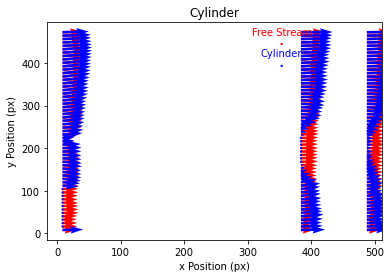

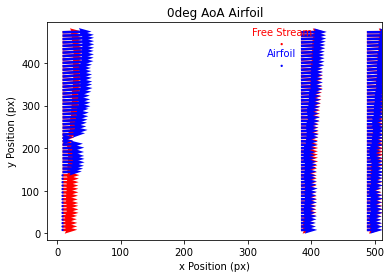

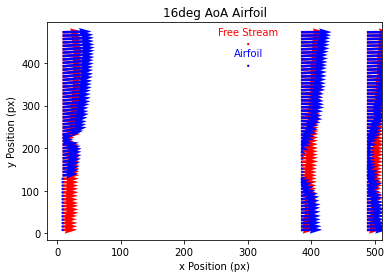

In [44]:
#For the Cylinder
fs = plt.quiver(x_fs[0::79], y_fs[0::79], u_fs[0::79], v_fs[0::79], label="fs", color="red")
plt.quiver(x_fs[60::79], y_fs[60::79], u_fs[60::79], v_fs[60::79], color="red")
plt.quiver(x_fs[47::79], y_fs[47::79], u_fs[47::79], v_fs[47::79], color="red")
plt.quiverkey(fs, 0.6, 0.9, 1, label="Free Stream", labelcolor="red")
c = plt.quiver(x_c[0::79], y_c[0::79], u_c[0::79], v_c[0::79], label="c", color="blue")
plt.quiver(x_c[60::79], y_c[60::79], u_c[60::79], v_c[60::79], color="blue")
plt.quiver(x_c[47::79], y_c[47::79], u_c[47::79], v_c[47::79], color="blue")
plt.quiverkey(c, 0.6, 0.8, 1, label="Cylinder", labelcolor="blue")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("Cylinder")
plt.show()

#For Airfoil 0 AoA
fs = plt.quiver(x_fs[0::79], y_fs[0::79], u_fs[0::79], v_fs[0::79], label="fs", color="red")
plt.quiver(x_fs[60::79], y_fs[60::79], u_fs[60::79], v_fs[60::79], color="red")
plt.quiver(x_fs[47::79], y_fs[47::79], u_fs[47::79], v_fs[47::79], color="red")
plt.quiverkey(fs, 0.6, 0.9, 1, label="Free Stream", labelcolor="red")
af0 = plt.quiver(x_af0[0::79], y_af0[0::79], u_af0[0::79], v_af0[0::79], color="blue")
plt.quiver(x_af0[60::79], y_af0[60::79], u_af0[60::79], v_af0[60::79], color="blue")
plt.quiver(x_af0[47::79], y_af0[47::79], u_af0[47::79], v_af0[47::79], color="blue")
plt.quiverkey(af0, 0.6, 0.8, 1, label="Airfoil", labelcolor="blue")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("0deg AoA Airfoil")
plt.show()

#For Airfoil 16 AoA
fs = plt.quiver(x_fs[0::79], y_fs[0::79], u_fs[0::79], v_fs[0::79], label="fs", color="red")
plt.quiver(x_fs[60::79], y_fs[60::79], u_fs[60::79], v_fs[60::79], color="red")
plt.quiver(x_fs[47::79], y_fs[47::79], u_fs[47::79], v_fs[47::79], color="red")
plt.quiverkey(fs, 0.6, 0.9, 1, label="Free Stream", labelcolor="red")
af = plt.quiver(x_af[0::79], y_af[0::79], u_af[0::79], v_af[0::79], color="blue")
plt.quiver(x_af[60::79], y_af[60::79], u_af[60::79], v_af[60::79], color="blue")
plt.quiver(x_af[47::79], y_af[47::79], u_af[47::79], v_af[47::79], color="blue")
plt.quiverkey(af, 0.6, 0.8, 1, label="Airfoil", labelcolor="blue")
plt.xlabel("x Position (px)")
plt.ylabel("y Position (px)")
plt.title("16deg AoA Airfoil")
plt.show()

# Part 6

$$ C_{d_o} = \frac{1}{\frac{1}{2} \rho {U_{atm}^2}} \Sigma \left[ \frac{\rho (U_{atm}^2 - U_{downstream}^2)}{g} \right]$$

In [2]:
# Computing drag for each case

import pandas as pd
import numpy as np

# Constants
rho = 997 #kg/m^3
mu = 1.002E-3 #Ns/m^2


In [16]:
# Importing average data 
airfoil_0_raw = pd.read_csv('Summary Data\Average_Data Airfoil 0 AoA.csv')
airfoil_16_raw = pd.read_csv('Summary Data\Average_Data Airfoil AoA.csv')
cylinder_raw = pd.read_csv('Summary Data\Average_Data Cylinder.csv')
freestream_raw = pd.read_csv('Summary Data\Average_Data Free Stream.csv')

# Filtering data for only max x value
airfoil_0 = airfoil_0_raw[airfoil_0_raw['x'] == 632]
airfoil_16 = airfoil_16_raw[airfoil_16_raw['x'] == 632]
cylinder = cylinder_raw[cylinder_raw['x'] == 632]
freestream = freestream_raw[freestream_raw['x'] == 632]

In [23]:
# Joining each test case to the freestream data
Cds = []
for case in [airfoil_0, airfoil_16, cylinder]:
    joined = pd.merge(freestream, case, left_index = True, right_index = True, how='outer') # Join test case to freestream data
    joined['Cd'] = (1 / (.5 * rho * (joined['u_x']*.001)**2)) * ((rho / 9.81) * ((joined['u_x']*.001)**2 - (joined['u_y']*.001)**2)) # Compute drag coefficient at each Y position at max X
    Cd = joined['Cd'].sum() # Total drag coefficient
    Cds.append(Cd)

In [25]:
print(Cds)

[2.0037100858343124, 3.3694325880223737, 1.8800461501449182]
